In [1]:
!pip install munch
# !pip install imageio

In [2]:
from jax import jacfwd, jit
import jax.numpy as jnp
import plotly.graph_objects as go
from jax import vmap
from jax.scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import munch

In [10]:
np.set_printoptions(precision=20)


x_d = -2

In [11]:
class OnePopulationalMFG(object):
    def __init__(self, T, Nt, xl, xr, N, nu, alpha, eps):
        """
        Input:

        T:          float
                the terminal time

        Nt:         integer
                the number of time intervals

        xl:         float
                the left boundary of the interval

        xr:         float
                the right boundary of the interval

        N:          integer
                the number of intervals

        nu:         float
                the viscosity constant

        alpha:      float
                the coefficient of the susceptibility of the population

        eps:        float
                define the closeness of agents
        """
        self.T = T
        self.Nt = Nt
        self.dt = T / Nt
        self.xl = xl
        self.xr = xr
        self.N = N
        self.nu = nu
        self.alpha = alpha
        self.X = jnp.linspace(xl, xr, N, endpoint=False)
        self.h = (xr - xl) / N
        self.eps = eps

    def m0(self, x):
        #return jnp.ones(x.shape) / (self.xr - self.xl) # we impose the uniform distribution on [-1, 1]

        midpoint = (self.xr + self.xl) / 2
        sigma_mu = 1  # Define your standard deviation
        return norm.pdf(x, loc=midpoint, scale=sigma_mu)

    def uT(self, x):
        return (x - x_d) ** 2

    def r(self, x):
        return 1 / (jnp.sum(vmap(lambda y: self.phi(x, y))(self.X)))/self.N

    def phi(self, x, y):
        dist = jnp.minimum(jnp.abs(x - y), self.eps)
        res = jnp.exp(1 - self.eps**2 / (1e-40 + self.eps**2 - dist**2))  #add a small number to prevent from dividing by zero
        return res

    def b(self, x, m):
        interaction = jnp.sum(vmap(lambda y: self.phi(x, y))(self.X) * self.X * m) / self.N

        return self.alpha * x - self.alpha * self.r(x) * interaction

    def g(self, x, q1, q2, m):
        p1 = jnp.minimum(q1, 0)
        p2 = jnp.maximum(q2, 0)
        b = self.b(x, m)
        b1 = jnp.minimum(b, 0)
        b2 = jnp.maximum(b, 0)
        return (p1 ** 2) / 2 + (p2 ** 2) / 2 + b1 * q1 + b2 * q2

    def hamilton(self, U, M):
        dUR = (jnp.roll(U, -1) - U)/self.h
        dUL = (U - jnp.roll(U, 1))/self.h

        Hamiltonian = vmap(lambda x, q1, q2: self.g(x, q1, q2, M))(self.X, dUR, dUL)
        return Hamiltonian

    def fp_linearized_part(self, U, M):
        UR = (jnp.roll(U, -1) - U) / self.h
        UL = (U - jnp.roll(U, 1)) / self.h

        URF = UR.flatten()
        ULF = UL.flatten()

        dGq1 = lambda x1, q1, q2: jnp.minimum(q1, 0)
        dGq2 = lambda x1, q1, q2: jnp.maximum(q2, 0)

        dGq1s = vmap(dGq1)(self.X, URF, ULF)
        dGq2s = vmap(dGq2)(self.X, URF, ULF)

        dGq1s = jnp.multiply(dGq1s, M)
        dGq2s = jnp.multiply(dGq2s, M)

        dGqDifference1 = dGq1s - dGq2s

        dGqs2R = jnp.roll(dGq2s, -1)
        dGqs1L = jnp.roll(dGq1s, 1)

        A = - (dGqDifference1 + dGqs2R - dGqs1L) / self.h

        # consider the effect of b(x)
        b = vmap(lambda x: self.b(x, M))(self.X)
        bp1 = lambda x: jnp.minimum(x, 0)
        bp2 = lambda x: jnp.maximum(x, 0)

        bp1s = vmap(bp1)(b)
        bp2s = vmap(bp2)(b)

        bp1s = jnp.multiply(bp1s, M)
        bp2s = jnp.multiply(bp2s, M)

        bpDifference1 = bp1s - bp2s

        bp2sR = jnp.roll(bp2s, -1)
        bp1sL = jnp.roll(bp1s, 1)

        B = - (bpDifference1 + bp2sR - bp1sL) / self.h

        MEQByHands = A + B
        return MEQByHands

    def hjb(self, t, Uk1, Uk, Mk1):
        UR = jnp.roll(Uk, -1)
        UL = jnp.roll(Uk, 1)

        Delta_U = - (2 * Uk - UR - UL) / self.h ** 2

        Dt_U = (Uk1 - Uk) / self.dt

        Hamiltonian = self.hamilton(Uk, Mk1)

        return -Dt_U - self.nu * Delta_U + Hamiltonian - Mk1



    def fp(self, Uk, Mk1, Mk):
        Dt_M = (Mk1 - Mk) / self.dt

        Mk1R = jnp.roll(Mk1, -1)
        Mk1L = jnp.roll(Mk1, 1)

        Delta_M = - (2 * Mk1 - Mk1R - Mk1L) / self.h**2


        adj = self.fp_linearized_part(Uk, Mk1)

        return Dt_M - self.nu * Delta_M + adj

    def hjb_sys(self, U, M):
        """
        Input:

        U:      matrix
            (Nt + 1) x N matrix, each row contains the values of U at the grid points
            the first row represents the time 0 and the last row contains the data at time T

        M:      matrix
            (Nt + 1) x N matrix, each row contains the values of M at the grid points
            the first row represents the time 0 and the last row contains the data at time T
        """
        ts = jnp.linspace(0, self.T, self.Nt + 1)
        hjbs = vmap(self.hjb)(ts[:-1], U[1:, :], U[:-1, :], M[1:, :])

        return hjbs


    def fp_sys(self, U, M):
        fps = vmap(self.fp)(U[:-1, :], M[1:, :], M[:-1, :])

        return fps


    def prolong(self, Uvec, Mvec):
        Umtx = jnp.reshape(Uvec, (self.Nt, self.N))
        Mmtx = jnp.reshape(Mvec, (self.Nt, self.N))

        U = jnp.zeros((self.Nt + 1, self.N))
        M = jnp.zeros((self.Nt + 1, self.N))

        U = U.at[:self.Nt, :].set(Umtx)
        M = M.at[1:, :].set(Mmtx)

        # compute the values of m at time 0 and the values of u at time T
        M0 = vmap(self.m0)(self.X)
        UT = vmap(self.uT)(self.X)

        U = U.at[self.Nt, :].set(UT)
        M = M.at[0, :].set(M0)
        return U, M


    def hjb_sys_vec(self, Uvec, Mvec):
        U, M = self.prolong(Uvec, Mvec)
        return self.hjb_sys(U, M).flatten()

    def fp_sys_vec(self, Mvec, Uvec):
        U, M = self.prolong(Uvec, Mvec)
        return self.fp_sys(U, M).flatten()

    def solve_hjb(self, U0, M, lr, tol=10**(-6), epoch=100):
        error = 1
        iter_num = 0

        U = U0
        while error > tol and iter_num < epoch:
            b = self.hjb_sys_vec(U, M)
            jacobi = jacfwd(self.hjb_sys_vec)(U, M)
            dz = jnp.linalg.solve(jacobi, b.flatten())
            U = U - lr * dz

            error = jnp.dot(dz, dz)
            print("             the error of solving hjb is {}".format(error))

            iter_num = iter_num + 1

        return U

    def solve_fp(self, M0, U):
        jacobi = jacfwd(self.fp_sys_vec)(M0, U)
        b = self.fp_sys_vec(jnp.zeros(len(jacobi)), U)
        M = jnp.linalg.lstsq(jacobi, -b)
        return M[0]

    def solve(self, tol=10**(-6), epoch=100, hjb_lr = 1, hjb_epoch = 100):
        U = jnp.zeros((self.Nt, self.N)).flatten()
        M = jnp.zeros((self.Nt, self.N)).flatten()

        error = 1
        iter_num = 0
        while error > tol and iter_num < epoch:
            U1 = self.solve_hjb(U, M, hjb_lr, epoch = hjb_epoch)
            M1 = self.solve_fp(M, U1)

            Uerr = U1 - U
            Merr = M1 - M

            error = jnp.dot(Uerr, Uerr) + jnp.dot(Merr, Merr)
            print('the mfg error is {}'.format(error))

            iter_num = iter_num + 1

            U = U1
            M = M1

        U, M = self.prolong(U, M)
        return U, M



In [12]:
cfg = munch.munchify({
    'T' : 1,
    'Nt': 70,
    'xl': -4,
    'xr': 4,
    'N' : 70,
    'nu': 1,
    'alpha': 1,
    'eps': 1,
    'hjb_epoch': 100,
    'hjb_lr': 1,
    'epoch': 100,
    'lr': 1,
    'tol' : 10 ** (-7),
})

In [13]:
solver = OnePopulationalMFG(cfg.T, cfg.Nt, cfg.xl, cfg.xr, cfg.N, cfg.nu, cfg.alpha, cfg.eps)

TT = jnp.linspace(0, cfg.T, cfg.Nt + 1)
XX = jnp.linspace(cfg.xl, cfg.xr, cfg.N, endpoint=False)
TT, XX = jnp.meshgrid(TT, XX)


U, M = solver.solve(cfg.tol, cfg.epoch, cfg.hjb_lr, cfg.hjb_epoch)

             the error of solving hjb is 365765.15625
             the error of solving hjb is 37738.3359375
             the error of solving hjb is 3683.00244140625
             the error of solving hjb is 516.2659912109375
             the error of solving hjb is 20.057334899902344
             the error of solving hjb is 0.08253209292888641
             the error of solving hjb is 2.0797126580873737e-06
             the error of solving hjb is 1.0309731540703027e-10
the mfg error is 142913.359375
             the error of solving hjb is 89.6168441772461
             the error of solving hjb is 0.0018831456545740366
             the error of solving hjb is 1.0588505072739451e-10
the mfg error is 88.95472717285156
             the error of solving hjb is 0.005856134928762913
             the error of solving hjb is 1.337074451157605e-09
the mfg error is 0.005913448054343462
             the error of solving hjb is 5.973883617116371e-06
             the error of solving hjb is 1.12655

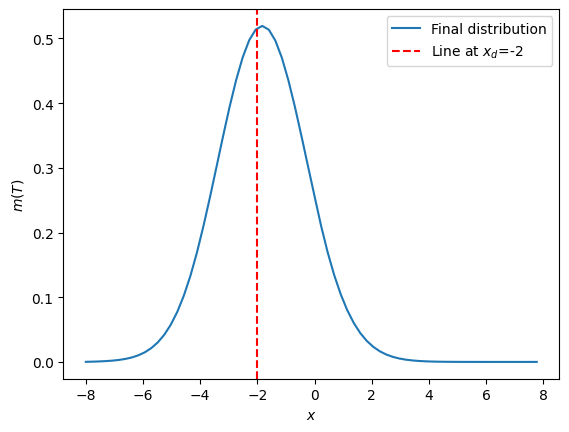

In [14]:
TT = jnp.linspace(0, cfg.T, cfg.Nt + 1)
XX = jnp.linspace(-8, 8, cfg.N, endpoint=False)

# Plot for M[-1, :] with a vertical line at x_d
fig = plt.figure()
# plt.plot(XX, M[0, :], label="Initial distribution")
plt.plot(XX, M[-1, :], label="Final distribution")
plt.axvline(x=x_d, color='r', linestyle='--', label=r"Line at $x_{d}$="+f'{x_d}')
plt.xlabel(r"$x$")
plt.ylabel(r"$m(T)$")
# plt.title("Final Distribution $m(T)$")
plt.legend()
plt.savefig("one_pop_with_initial.png", dpi=300)

plt.show()